In [962]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)


np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

In [862]:
data_dir="/home/tomren/geant_projects/musim_test/cedar"
data_dir="/home/tomren/geant_projects/musim_test/cedar_cosmic_n"
fname_comb = f"{data_dir}/series_2_digi_recon_skim.root"
fname_comb = "/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/merged.root"
fname_sig1 = "/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root"
fname_sig2 = "/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root"

fbkg = root.tfile_reader(fname_comb)
fbkg.ls()
fbkg.get_tree("data;1")
print("Entries", fbkg.entries)

fsig1 = root.tfile_reader(fname_sig1)
fsig1.ls()
fsig1.get_tree("data;1")
print("Entries", fsig1.entries)

fsig2 = root.tfile_reader(fname_sig2)
fsig2.ls()
fsig2.get_tree("data;1")
print("Entries", fsig1.entries)

None
Entries 5037
None
Entries 8726
None
Entries 8726
TFile**		/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/merged.root	
 TFile*		/home/tomren/geant_projects/musim_test/cedar/cosmic/cosmic_p/skim/merged.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TParameter<int>	N_MERGED;1	
  KEY: TTree	data;1	Reconstruction Tree Skimmed
TFile**		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_25_digi_recon_skim.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TTree	data;1	Reconstruction Tree Skimmed
TFile**		/home/tomren/geant_projects/musim_test/llp_hxx_bb/run_45_digi_recon_skim.root	
 TFile*		/home/tomren/geant_projects/musim_test/llp_hxx_bb/ru

In [868]:
res_bkg = cut_functions.run_processing(fbkg, entries=10000);
res_sig1 = cut_functions.run_processing(fsig1, entries=1000);
res_sig2 = cut_functions.run_processing(fsig2, entries=1000);

colors = ["C0", "C2", "C1"]


Entries 5037
Finished
Entries 8726
Finished
Entries 8668
Finished


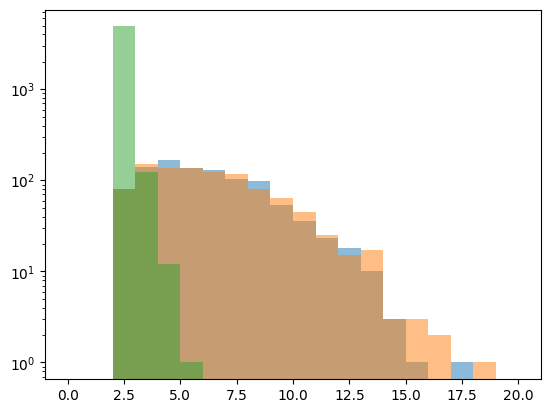

In [923]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    # plt.hist(res["vertex_ntracks"] - res["vertex_ndownward_track"], bins=20,range=(0,20), alpha=0.5);
    plt.hist(res["vertex_ntracks"], bins=20,range=(0,20), alpha=0.5);
plt.yscale("log")
plt.show()

(0.0, 120.0)

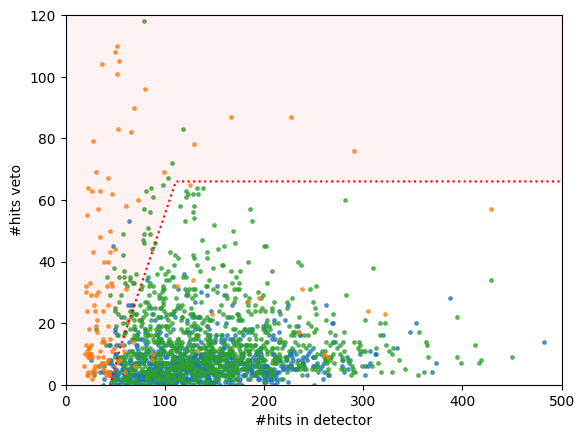

In [997]:
f_nhits_cut = lambda x: (x-45)*1.2  * (x < 100) +  (100-45)*1.2 * (x >= 100) 
c_nhits = lambda data: res["event_ndigi_veto"] < f_nhits_cut(res["event_ndigi_active_after"])
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    
    res.add_cut(lambda data: np.ones_like(data["vertex_ntracks"], dtype=bool), "True")
    res.add_cut(lambda data: data["vertex_ntracks"]>2, "N_tracks")
    res.add_cut(c_nhits, "N_hits vs N_veto")

    
    mask = res.get_cut("N_tracks") #| res.get_cut("True")
    x = res["event_ndigi_active_after"][mask]
    y = res["event_ndigi_veto"][mask]
    plt.scatter(x, y, alpha=0.7, s=6, color=colors[i])

x_plot = np.linspace(0,500,10)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), 120, color="r", alpha=0.05)
plt.xlabel("#hits in detector")
plt.ylabel("#hits veto")
plt.xlim(0,500)
plt.ylim(0,120)



893
873
24


(0.0, 30.0)

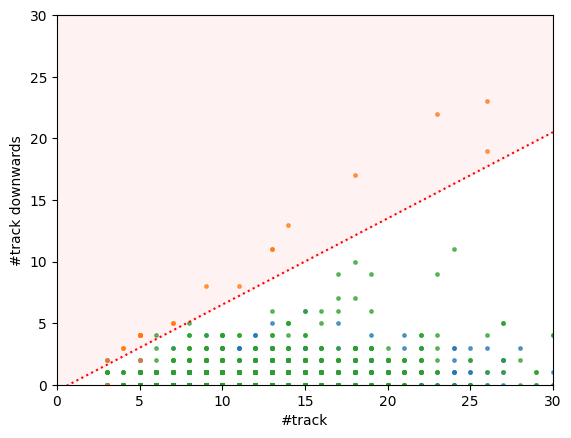

In [924]:
f_ndown_cut = lambda x: x*0.7-0.5
c_ndown = lambda data: res["event_ndownward_track"] < f_ndown_cut(res["event_ntracks"])

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_ndown, "N track downward")

    mask = res.get_cut("N_hits vs N_veto") & res.get_cut("N_tracks") #| res.get_cut("True")
    print(sum(mask))
    
    x = (res["event_ntracks"])[mask]
    y = res["event_ndownward_track"][mask]
    plt.scatter(x, y, alpha=0.7, s=6, color=colors[i])


xlim=30
ylim=30
x_plot = np.linspace(0,xlim,10)
plt.plot(x_plot, f_ndown_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_ndown_cut(x_plot), ylim, color="r", alpha=0.05)
plt.xlabel("#track")
plt.ylabel("#track downwards")
plt.xlim(0,xlim)
plt.ylim(0,ylim)


951
928
19


(0.0, 10.0)

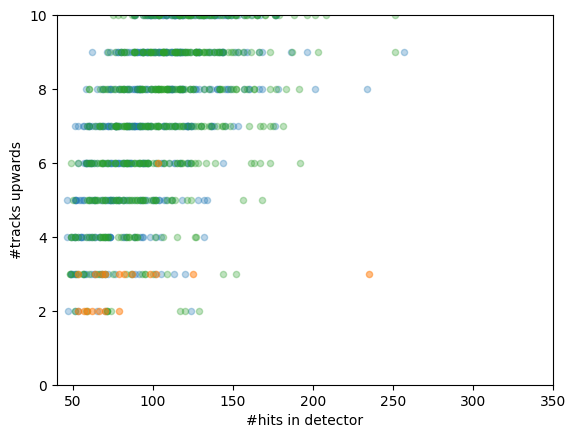

In [1014]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N_hits vs N_veto") & res.get_cut("N track downward") #&res.get_cut("N_tracks") | res.get_cut("True")
    print(sum(mask))
    
    x = (res["event_ndigi_active"] - res["vertex_ndigi_active_before"])[mask]
    y = (res["event_ntracks"] - res["event_ndownward_track"])[mask]
    # y = (res["vertex_ntracks"] - res["vertex_ndownward_track"])[mask]
    plt.scatter(x, y, alpha=0.3+ np.heaviside(i-1, 0) * 0.2, s=20, color=colors[i])

plt.xlabel("#hits in detector")
plt.ylabel("#tracks upwards")
plt.xlim(40,350)
plt.ylim(0,10)

951
928
19


(0.0, 10.0)

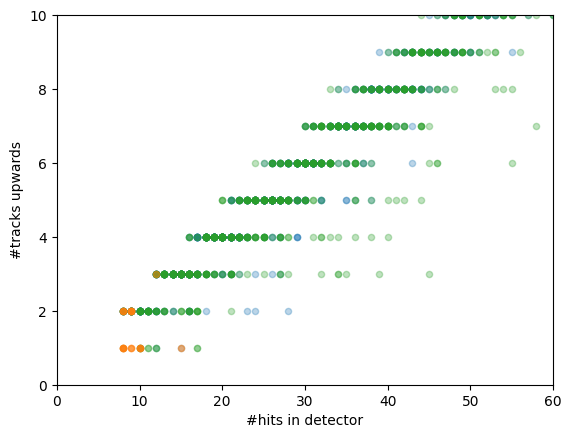

In [1021]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N_hits vs N_veto") & res.get_cut("N track downward") #&res.get_cut("N_tracks")# | res.get_cut("True")
    print(sum(mask))
    
    x = (res["vertex_ndigi"])[mask]
    # y = (res["event_ntracks"] - res["event_ndownward_track"])[mask]
    y = (res["vertex_ntracks"] - res["vertex_ndownward_track"])[mask]
    plt.scatter(x, y, alpha=0.3+ np.heaviside(i-1, 0) * 0.2, s=20, color=colors[i])

plt.xlabel("#hits in detector")
plt.ylabel("#tracks upwards")
plt.xlim(0,60)
plt.ylim(0,10)

951
928
19


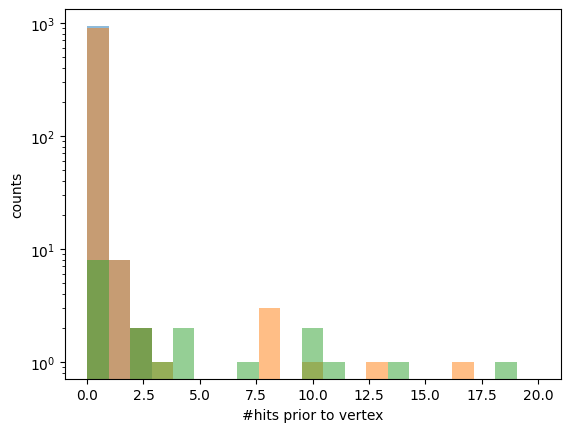

In [932]:
c_track_before = lambda data: res["vertex_ndigi_before"] <= 1

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_track_before, "N digi before")
    mask =  res.get_cut("N_hits vs N_veto") & res.get_cut("N track downward")
    # mask = res.get_cut("True")
    print(sum(mask))    
    plt.hist(res["vertex_ndigi_before"][mask], range=(0,20), bins=21, alpha=0.5)
plt.xlabel("#hits prior to vertex")
plt.ylabel("counts")
plt.yscale("log")

949
918
8


Text(0, 0.5, 'Vertex-CMS angle deviation [rad]')

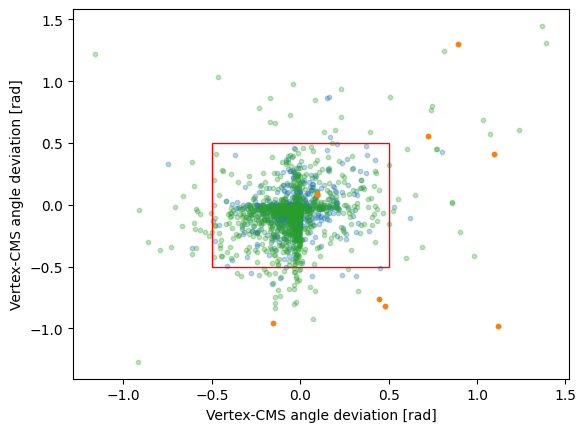

In [969]:
c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"])<0.5) & (abs(res["vertex_cms_angle_v"]) < 0.5)

for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    res.add_cut(c_angle_hv, "Angle to CMS")
    mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N digi before")
    print(sum(mask))
    x = res["vertex_cms_angle_h"][mask]
    y = res["vertex_cms_angle_v"][mask]
    plt.scatter(x, y, alpha=0.3 + np.heaviside(i-1, 0) * 0.7, s=10, color=colors[i])

plt.gca().add_patch(mpl.patches.Rectangle([-0.5,-0.5],1,1,facecolor="none", ec="r"))

plt.xlabel("Vertex-CMS angle deviation [rad]")
plt.ylabel("Vertex-CMS angle deviation [rad]")
# plt.yscale("log")

933
825
1


Text(0, 0.5, 'Vertex-CMS deviation [rad]')

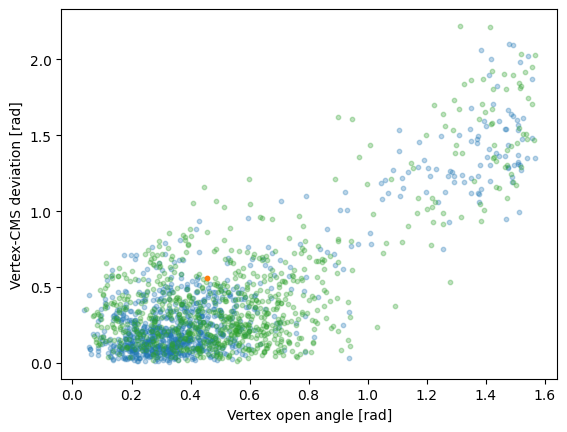

In [1002]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")
    print(sum(mask))

    x = res["vertex_open_angle"][mask]
    y = res["vertex_cms_angle"][mask]
    plt.scatter(x, y, alpha=0.3 + np.heaviside(i-1, 0) * 0.7, s=10, color=colors[i])

plt.xlabel("Vertex open angle [rad]")
plt.ylabel("Vertex-CMS deviation [rad]")
# plt.yscale("log")

933
825
1


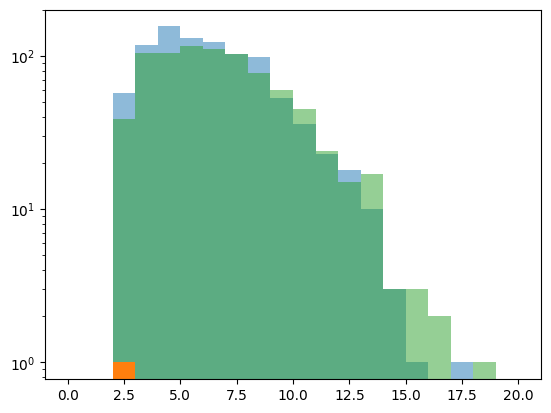

In [1003]:
for i, res in enumerate([res_sig1, res_sig2, res_bkg]):
    mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")
    print(sum(mask))
    # plt.hist((res["vertex_ntracks"] - res["vertex_ndownward_track"])[mask], bins=20,range=(0,20), alpha=0.5);
    plt.hist(res["vertex_ntracks"][mask], bins=20,range=(0,20), alpha=0.5+ np.heaviside(i-1, 0) * 0.5, color=colors[i]);
plt.yscale("log")
plt.show()

1
17


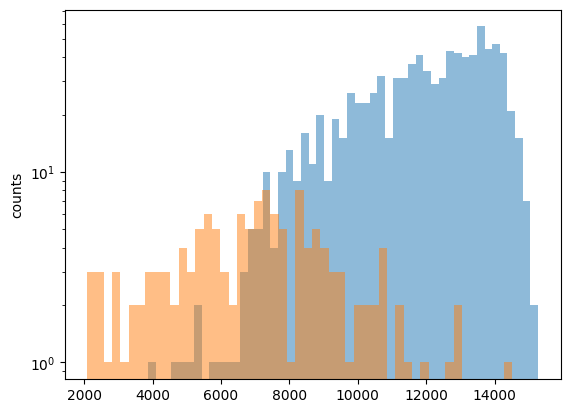

In [816]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # plt.hist(res["vertex_hits_trend_3"], bins=51, alpha=0.5)
    plt.hist(res["vertex_hits_trend_3"][mask_basic], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_3"][mask_basic & (res["vertex_topfrac"]>0.5)], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_3"][mask_basic & (res["vertex_topfrac"]<=0.5)], bins=51, alpha=0.5)
    print(sum(res["vertex_hits_trend_3"][mask_basic]<4000))
plt.ylabel("counts")
plt.yscale("log")

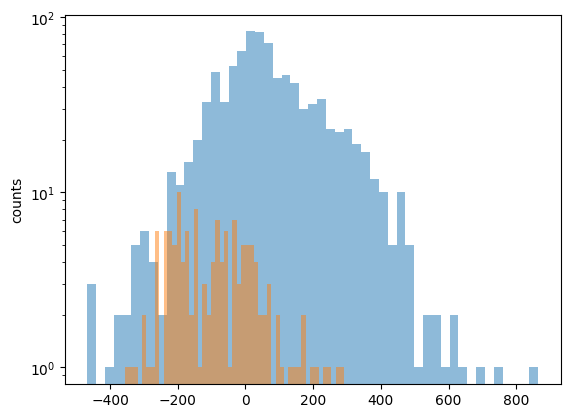

In [789]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # plt.hist(res["vertex_hits_trend_3"], bins=51, alpha=0.5)
    plt.hist(res["vertex_hits_trend_2"][mask_basic], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_2"][mask_basic & (res["vertex_topfrac"]>0.5)], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_2"][mask_basic & (res["vertex_topfrac"]<0.5)], bins=51, alpha=0.5)
plt.ylabel("counts")
plt.yscale("log")

Text(0, 0.5, 'counts')

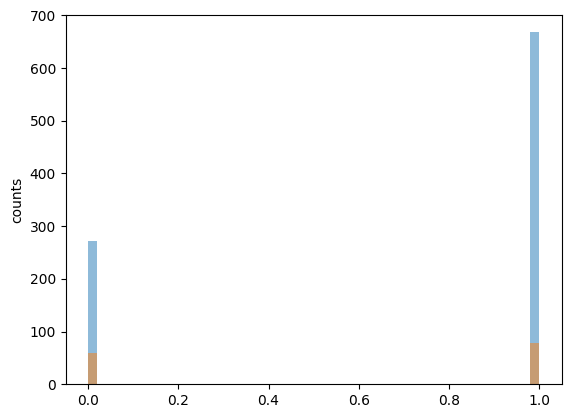

In [910]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # plt.hist(res["vertex_hits_trend_1"].astype(int), bins=51, alpha=0.5)
    plt.hist(res["vertex_hits_trend_1"].astype(int)[mask_basic], bins=51, alpha=0.5)
plt.ylabel("counts")
# plt.yscale("log")

(0.0, 120.0)

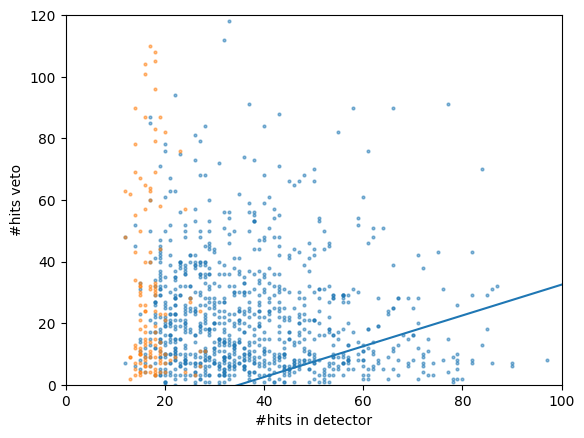

In [848]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # plt.scatter(res["event_ndigi_active"], res["event_ndigi_veto"], alpha=0.5, s=4)
    # plt.scatter(res["event_ndigi_active"][mask_basic], res["event_ndigi_veto"][mask_basic], alpha=0.5, s=4)
    plt.scatter((res["vertex_ntracklet_3+"] + res["vertex_ndigi"])[mask_basic], res["event_ndigi_veto"][mask_basic], alpha=0.5, s=4)

f_nhits_cut = lambda x: (x-35)*1/2
plt.plot(np.linspace(0,500,10), f_nhits_cut(np.linspace(0,500,10)))
plt.xlabel("#hits in detector")
plt.ylabel("#hits veto")
plt.xlim(0,100)
plt.ylim(0,120)



In [809]:
res["event_ndownward_track"]

array([0.   , 0.   , 0.5  , 0.333, 0.   , 0.75 , 0.333, 0.   , 0.333, 0.333, 0.   , 0.333, 0.   , 0.5  , 0.   , 0.333, 0.5  , 0.   , 0.333, 0.25 , 0.   , 0.25 , 0.75 , 0.333, 0.   , 0.5  , 0.5  , 0.333, 0.5  , 0.333, ..., 0.5  , 0.   , 0.   , 0.   , 0.667, 0.333, 0.2  , 0.5  , 0.   , 0.75 , 0.   , 0.333, 0.   , 0.333, 0.667, 0.667, 0.5  , 0.8  , 0.   , 0.333, 0.625, 0.   , 0.   , 0.   , 0.   , 0.333, 0.333, 0.667, 0.5  , 0.714])

Text(0, 0.5, 'counts')

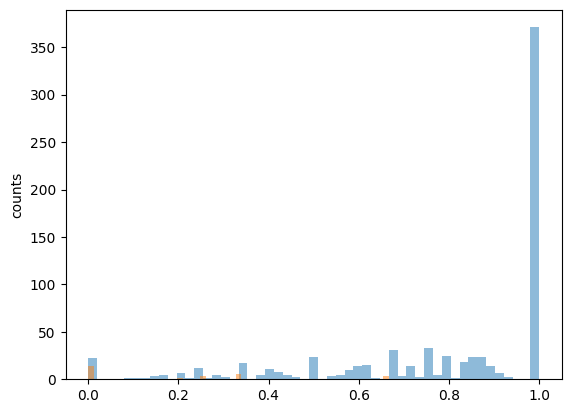

In [851]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    mask_nhits = f_nhits_cut(res["event_ndigi_active_after"]) > res["event_ndigi_veto"]
    plt.hist(res["vertex_topfrac"][mask_basic&mask_nhits], bins=51, alpha=0.5)
    # plt.hist(res["vertex_hits_trend_2"][mask_basic & (res["vertex_topfrac"]<0.5)], bins=51, alpha=0.5)
plt.ylabel("counts")
# plt.yscale("log")

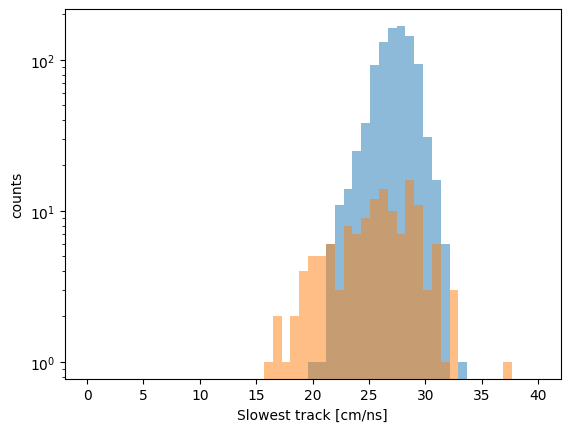

In [857]:
for res in [res_sig, res_bkg]:
    mask_basic = res["vertex_ntracks"]>2
    # mask_nhits = f_nhits_cut(res["event_ndigi_active_after"]) > res["event_ndigi_veto"]
    plt.hist(res["vertex_slowest_track"][mask_basic]/10, range=(0,40), bins=51, alpha=0.5)
plt.xlabel("Slowest track [cm/ns]")
plt.ylabel("counts")
plt.yscale("log")

1
0 4054


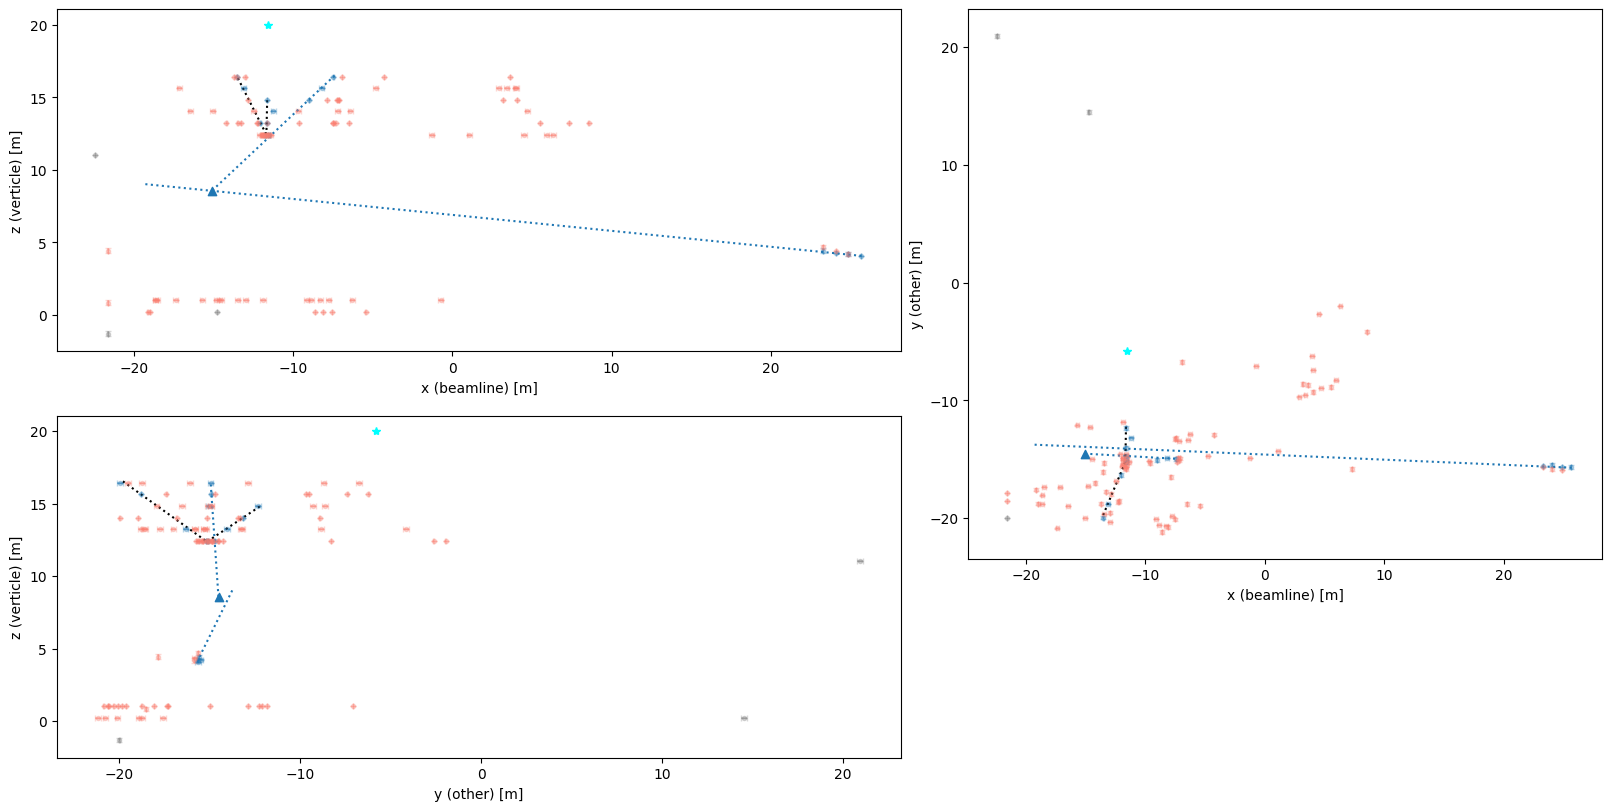

In [1004]:
res = res_bkg
mask = res.get_cut("N track downward") & res.get_cut("N_hits vs N_veto") & res.get_cut("N digi before") & res.get_cut("Angle to CMS")
print(sum(mask))
plotinds = np.flatnonzero(mask)

i+=1
i=0
j=plotinds[i]
print(i, j)

data = fbkg.get_entry(j)
event = datatypes.Event(data, metadata_digi)  
event.plot()

138
Is top, False
79
75
[10272.731363932291, 8071.797770182292, 5349.173068576389, 5029.164090474446] -126.3390522324134 [20853.691080729168, 22094.638346354168, 23622.854817708332, 22997.919813368055]


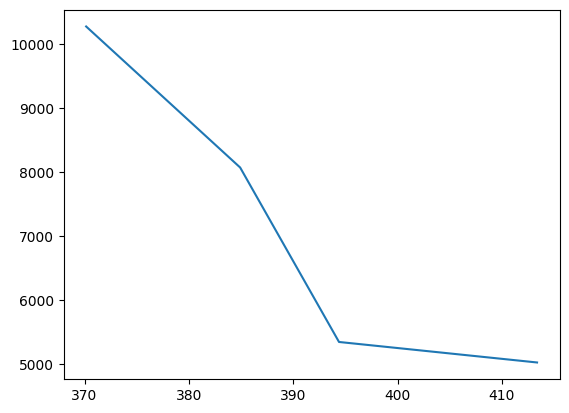

In [516]:
# i=0
i+=1
print(i)
j=plotinds[i]

data = fbkg.get_entry(j)
# data = fsig.get_entry(i)


## Check if the vertex is mostly with top or side tracks
event = datatypes.Event(data, metadata_digi)  
ntracks=[]
for j in range(len(event.vertices)):
    v = event.vertices[j]
    ntracks.append(v.ntracks)
i_vertex = np.argmax(ntracks)
v =  event.vertices[i_vertex]
tracks_are_top = [event.tracks[i].iv_index == 2 for i in v.track_ids]
vertex_is_top  = (sum(tracks_are_top)/len(tracks_are_top))>=0.5
print("Is top,", vertex_is_top)
    


ndiv = 4
digi_t = np.array(data["Digi_t"])
digi_t_inds = np.argsort(digi_t).astype(int)
digi_t_sorted = digi_t[digi_t_inds]

mask, tmean, t_std = util.removeoutliers(digi_t, skew_itermax=1, std_itermax=1)
print(len(digi_t_inds))
t_std = max(t_std*2, 300)
t_std = min(t_std, 300)
digi_t_inds = digi_t_inds[(digi_t_sorted<(tmean + t_std)) & 
                          (digi_t_sorted>(tmean - t_std))]
print(len(digi_t_inds))

xs,ys,zs,ts = [],[],[],[]
for igroup in range(ndiv):
    inds = digi_t_inds[len(digi_t_inds)//ndiv*igroup: len(digi_t_inds)//ndiv*(igroup+1)]
    xs.append(np.mean(np.array(data["Digi_x"])[inds]))
    ys.append(np.mean(np.array(data["Digi_y"])[inds]))
    zs.append(np.mean(np.array(data["Digi_z"])[inds]))
    ts.append(np.mean(np.array(data["Digi_t"])[inds]))
    # print(np.array(data["Digi_z"])[inds])

            # 2. Check if the overall trend is going downwards
dzdt, intercept, r, p, std_err = scipy.stats.linregress(ts, zs)
print(zs, dzdt, xs)
plt.plot(ts, zs)

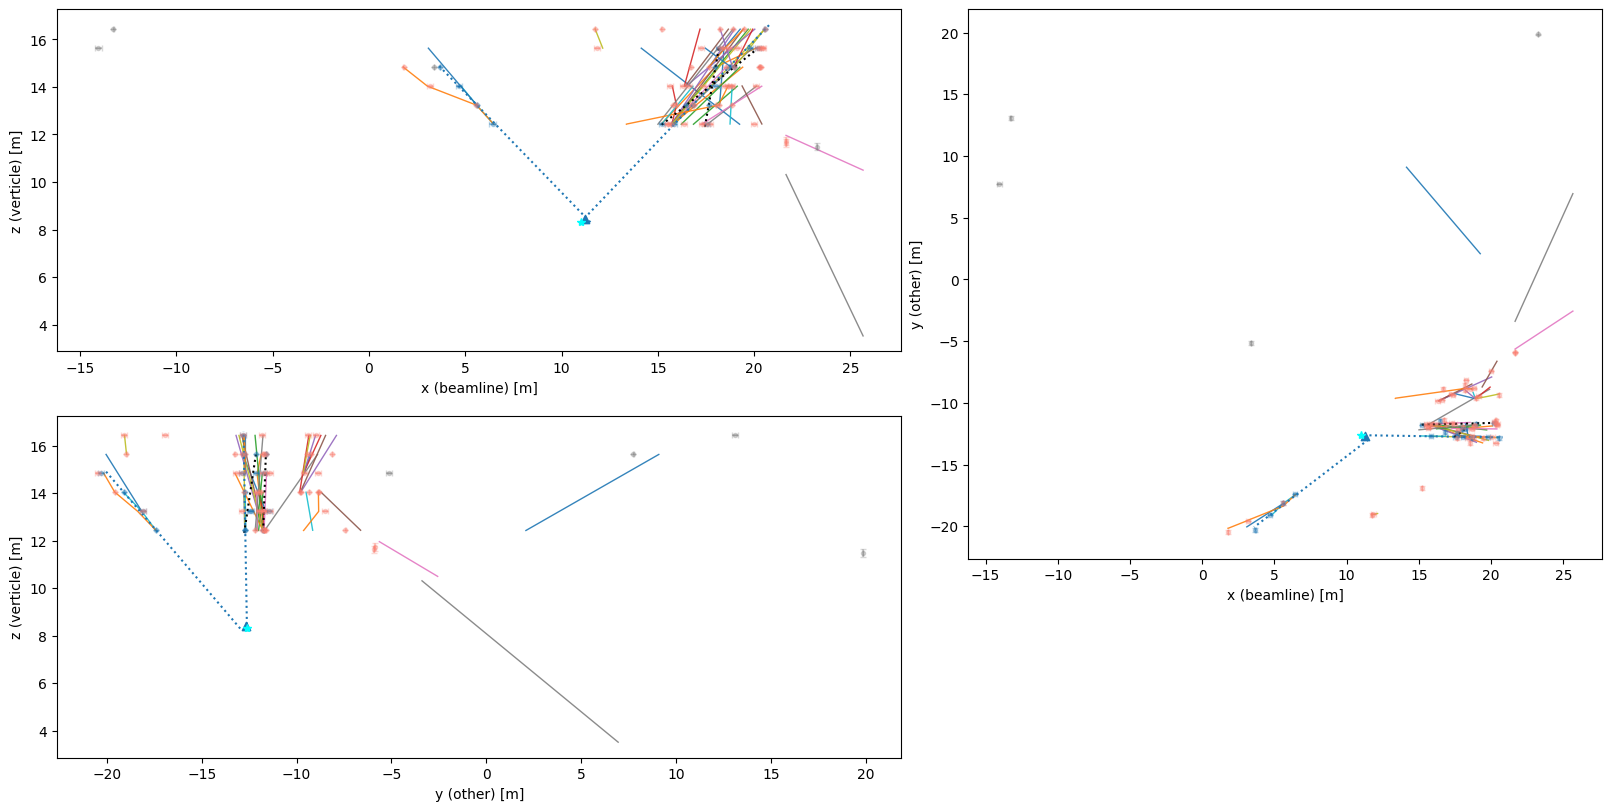

In [835]:
i+=1
data = fsig.get_entry(i)
# j=plotinds[i]
# data = fbkg.get_entry(j)
event = datatypes.Event(data, metadata_digi, parse_truth=True)  
event.plot()

In [200]:
digi_t_inds, digi_t, np.mean(digi_t_sorted)

(array([ 1, 31]),
 array([-477.237, -345.373, -546.867, -542.722, -492.702, -485.434, -479.765, -474.759, -467.991, -554.036, -554.312, -554.329, -548.031,  209.807, -506.809,  134.302, -551.797, -550.14 , -553.439, -431.875, -429.467, -427.109, -423.156, -421.446, -416.567, -431.238, -550.834, -548.575, -505.665, -540.891, -450.414, -226.824, 1280.711,  308.592,  340.738,  552.923, 1907.71 ,  311.334,  682.809,  459.936]),
 -207.52352981567384)

In [79]:
data["Track_kt"], data["Track_t0"], data["Vertex_t0"]

([0.0061717857606709,
  -0.004022068344056606,
  0.005835135001689196,
  0.0048088207840919495],
 [-263.46185302734375,
  -366.9369812011719,
  -294.78448486328125,
  -306.8486633300781],
 [-329.5685119628906])

In [23]:
data.keys()

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Digi_hitInds_unpacked', 'Track_cov_unpacked', 'Track_digiInds_unpacked', 'Vertex_cov_unpacked', 'Vertex_trackInds_unpacked'])